In [1]:
%matplotlib widget

In [2]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

import sys
sys.path.append("../slow_extraction_tutorial")
import plot_helpers

In [3]:
# Read MAD-X sequence from file (using cpymad)
from cpymad.madx import Madx
mad = Madx()
mad.option(echo=False)
mad.call('../../LATTICE/Prova3.seq') # Starting from electrostatic septum
mad.beam()
mad.use('CNAO3S0')


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2025.12.02 10:40:06      +
  ++++++++++++++++++++++++++++++++++++++++++++
assign, echo=output.out;





TITLE, "CNAO SYNC";







S0_001A_MBS: SBEND, L= 1.6772, 

E1 := 0.19634954085, E2 := 0.19634954085, ANGLE = 0.3926990817, 

K0 := 0.3926990817/1.6772, K1 := 0, K2 := 0, 

HGAP = 0.036, FINT:=FINTVAL;

S0_001B_TSP: MARKER;

S0_002A_DRI: DRIFT, L= 0.2101525103;

S0_003A_FLS: MARKER;

S0_004A_DRI: DRIFT, L= 0.109;

S0_005A_QUS: QUADRUPOLE, L= 0.36, 

K1 := KF;



S0_006A_BS1: MARKER;

S0_007A_DRI: DRIFT, L= 0.101;

S0_008A_FLS: MARKER;

S0_009A_PUH: HMONITOR, L= 0.3;

S0_010A_FLS: MARKER;

S0_011A_DRI: DRIFT, L= 0.061;

S0_012A_SSM: MARKER;

S0_013A_DRI: DRIFT, L= 0.056;

S0_014A_DIA: MARKER;

S0_015A_DRI: DRIFT, L= 0.033;

S0_016A_MSP: DRIFT, L= 0.65;

S0_017A_DRI: DRIFT, L= 0.9

In [4]:
# Import in Xsuite
line = xt.Line.from_madx_sequence(mad.sequence.CNAO3S0,
                                  deferred_expressions=True)

Converting sequence "cnao3s0":   0%|          | 0/392 [00:00<?, ?it/s]

In [5]:
# Choose the appropriate bend model
line.configure_bend_model(edge='full', core='adaptive', num_multipole_kicks=15)

In [6]:
line.particle_ref = xt.Particles(q0=1, mass0=xt.PROTON_MASS_EV,
                                 kinetic_energy0=60e6) # eV

### Match

In [7]:
# Build a single match with all constraints (can be reused to retune the machine)
opt = line.match(
    solve=False,
    method='4d',
    vary=[
        xt.VaryList(['s0', 's1'], step=1e-3, tag = 'sext'),
        xt.VaryList(['kf', 'kd','kr'], limits=(0, 1),  step=1e-3, tag='quad')
    ],
    targets=[
        xt.TargetSet(dqx=-3, dqy=-1, tol=1e-3, tag="chrom"),
        xt.Target(dx = 0, at='symp', tol=1e-6),
        xt.TargetSet(qx=1.666, tol=1e-6),
    ]
)
# Perform twenty optimization steps
opt.step(20)

                                             
Optimize - start penalty: 0.7412        
Matching: model call n. 30               
Optimize - end penalty:  6.79172e-05


In [8]:
# Inspect resonance sextupole's strength
line['sr']

-3.3

In [9]:
line.build_tracker()

The line already has an associated tracker


### Visualize the phase space topology

In [10]:
# Generate a particle on the x axis
x_gen = 1e-2
particles = line.build_particles(x=x_gen,px=0,y=0,py=0,delta=1e-3)

In [11]:
# Track 10000 turns logging turn-by-turn data
num_turns = 10000
line.track(particles,num_turns=num_turns, turn_by_turn_monitor=True)
rec = line.record_last_track

(-0.004, 0.004)

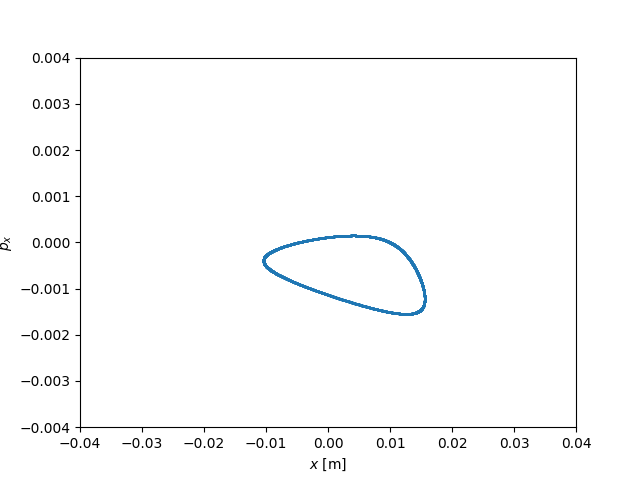

In [12]:
# Plot turn by turn data (physical phase space)
plt.figure()
plt.plot(rec.x, rec.px, '.', markersize=1, color='C0')
plt.ylabel(r'$p_x$')
plt.xlabel(r'$x$ [m]')
plt.xlim(-4e-2, 4e-2)
plt.ylim(-4e-3, 4e-3)

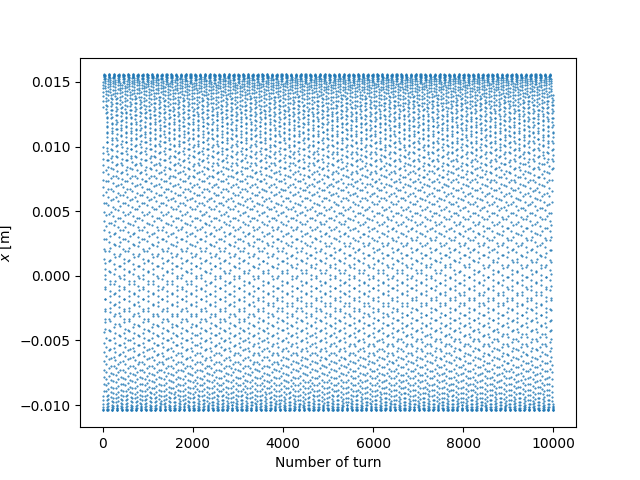

In [13]:
turns = np.arange(1, num_turns+1, 1, dtype=int)

# Plot for the first particle, for all turns
plt.figure()
plt.plot(turns, rec.x[0,:], '.', markersize=1, color='C0')
plt.xlabel("Number of turn")
plt.ylabel(r"$x$ [m]")
plt.show()

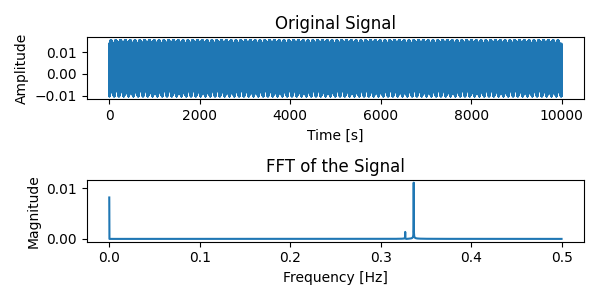

In [14]:
sampling_rate = 1 # Hz
T = 1.0 / sampling_rate  # Sample spacing (time interval)
N = 10000 # Number of sample points
t = np.linspace(0.0, N*T, N, endpoint=False)  # Time array

signal = rec.x[0,:]

# Compute the Fast Fourier Transform (FFT)
fft_signal = np.fft.fft(signal)

# Compute the frequency axis
frequencies = np.fft.fftfreq(N, T)[:N // 2]

# Compute the magnitude (absolute value) of the FFT
fft_magnitude = 2.0 / N * np.abs(fft_signal[:N // 2])

# Plot the original signal and its FFT
plt.close("all")
plt.figure(figsize=(6, 3))

# Plot the signal
plt.subplot(2, 1, 1)
plt.plot(t, signal)
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Plot the FFT
plt.subplot(2, 1, 2)
plt.plot(frequencies, fft_magnitude)
plt.title('FFT of the Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.tight_layout()

plt.show()

In [15]:
# Find the fractional tune of the particle

frequencies[np.argmax(fft_magnitude)]

np.float64(0.3365)

In [16]:
# Compute normalized coordinates
tw = line.twiss(method='4d', delta0=1e-3)
nc = tw.get_normalized_coordinates(rec)

In [17]:
# Tune and chromaticity
tw.qx, tw.dqx

(np.float64(1.6630234873937204), np.float64(-3.0000016009923414))

Text(0, 0.5, 'A')

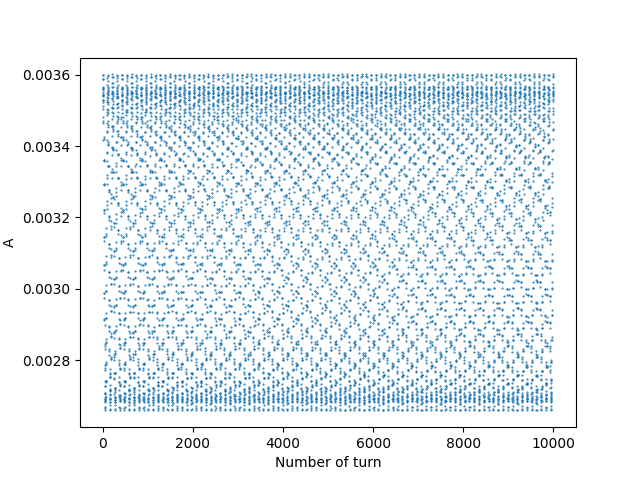

In [18]:
# Calculate the normalised amplitude and plot it over the turns
norm_amplitude = np.sqrt(nc.x_norm**2 + nc.px_norm**2)

plt.figure()
plt.plot(turns, norm_amplitude[0,:], '.', markersize=1)
plt.xlabel("Number of turn")
plt.ylabel("A")

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


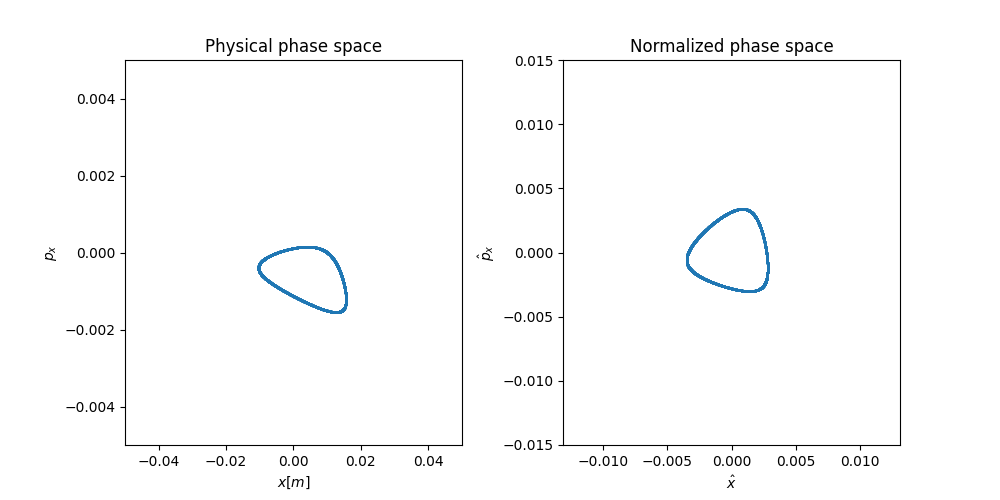

In [19]:
# Plot physical and normalised phase space side by side
ax_geom, ax_norm = plot_helpers.arrange_phase_space_plot() # empty plot

ax_geom.plot(rec.x.T, rec.px.T, '.', markersize=1, color='C0')
ax_norm.plot(nc.x_norm.T, nc.px_norm.T,
           '.', markersize=1, color='C0')